# DSCI 100 Group Project Proposal

Insert some introduction here

In [1]:
### Run this cell before continuing.
library(plyr)
library(dplyr)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('cleanup.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::r

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
stroke_data <- read_csv("data/healthcare-dataset-stroke-data.csv")
stroke_data

Rows: 5110 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): gender, ever_married, work_type, Residence_type, bmi, smoking_status
dbl (6): id, age, hypertension, heart_disease, avg_glucose_level, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
37544,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
44679,Female,44,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


To view what correlation various factors have on developing stroke, we will plot three scatter graphs: age vs. average glucose level, age vs. BMI, and BMI vs. average glucose level. These three variables were chosen because they were continuous measurements and are closely related to the develpopment of stroke. 

In [3]:
stroke_data_final <- stroke_data |>
                    mutate (stroke = as.factor(stroke),
                           bmi = as.numeric(bmi))
stroke_data_final
stroke_split <- initial_split(stroke_data_final, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split) 

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,NA,never smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
37544,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
44679,Female,44,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


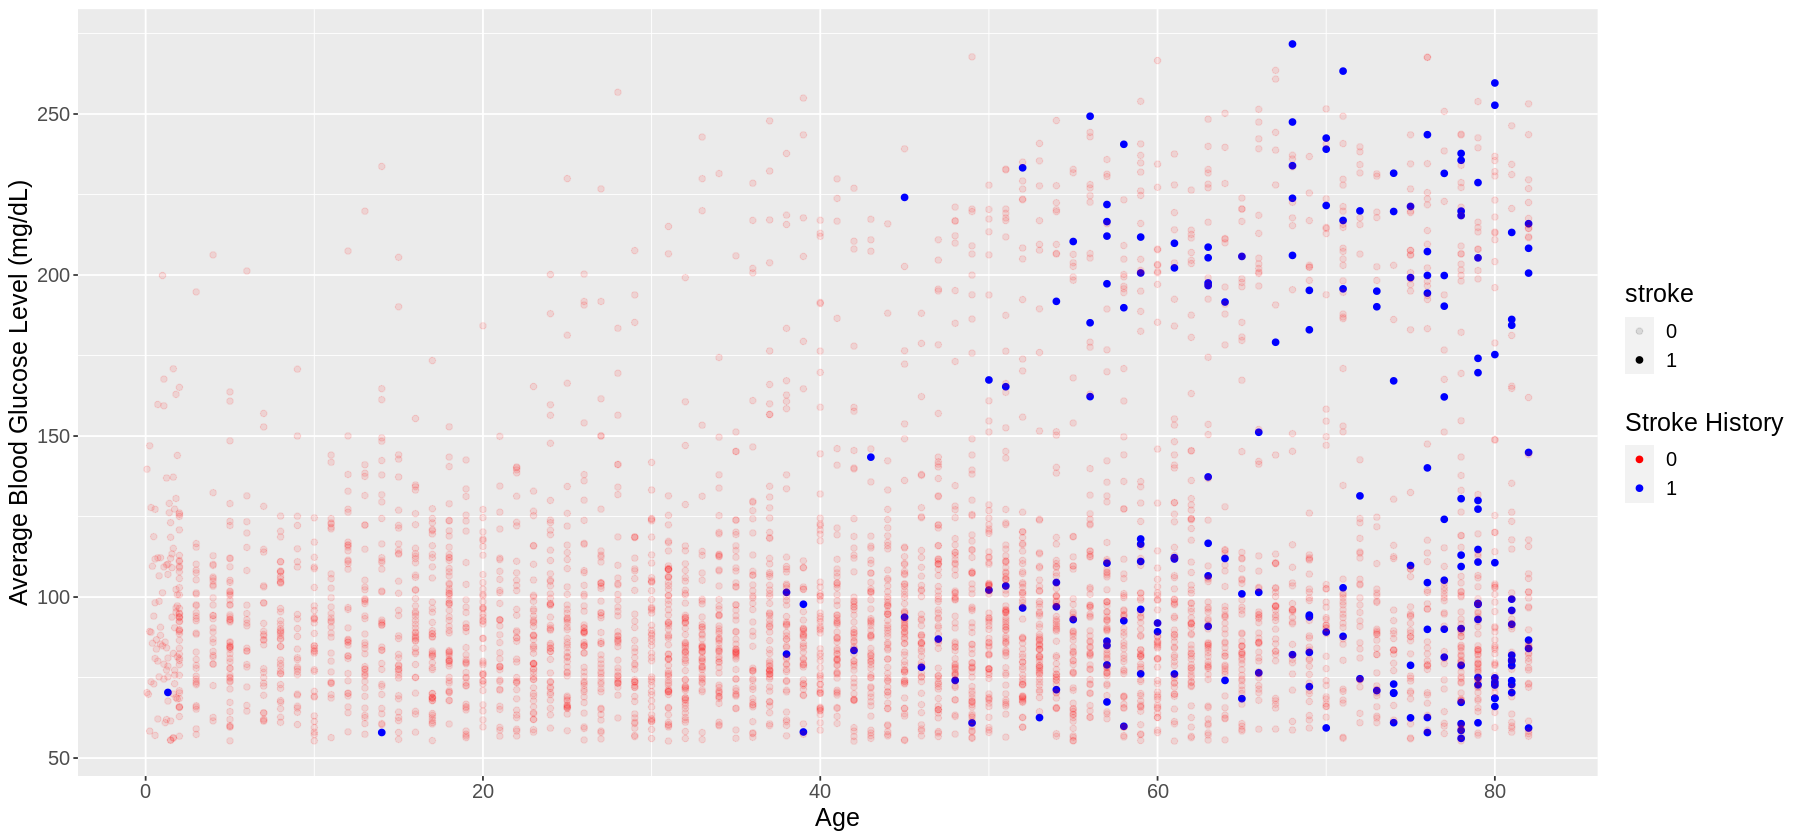

In [4]:
age_vs_glucose <- ggplot (stroke_train, aes(x=age, y=avg_glucose_level, color= stroke))+
                geom_point(aes(alpha = stroke))+
                scale_alpha_manual(values = c(0.1, 1))+
                scale_color_manual(values = c("red", "blue"))+
                labs(x="Age", y="Average Blood Glucose Level (mg/dL)", color = "Stroke History")+
                theme(text = element_text(size = 15))
options(repr.plot.width = 15, repr.plot.length = 20)

age_vs_glucose

Warning message:
“Removed 156 rows containing missing values (geom_point).”


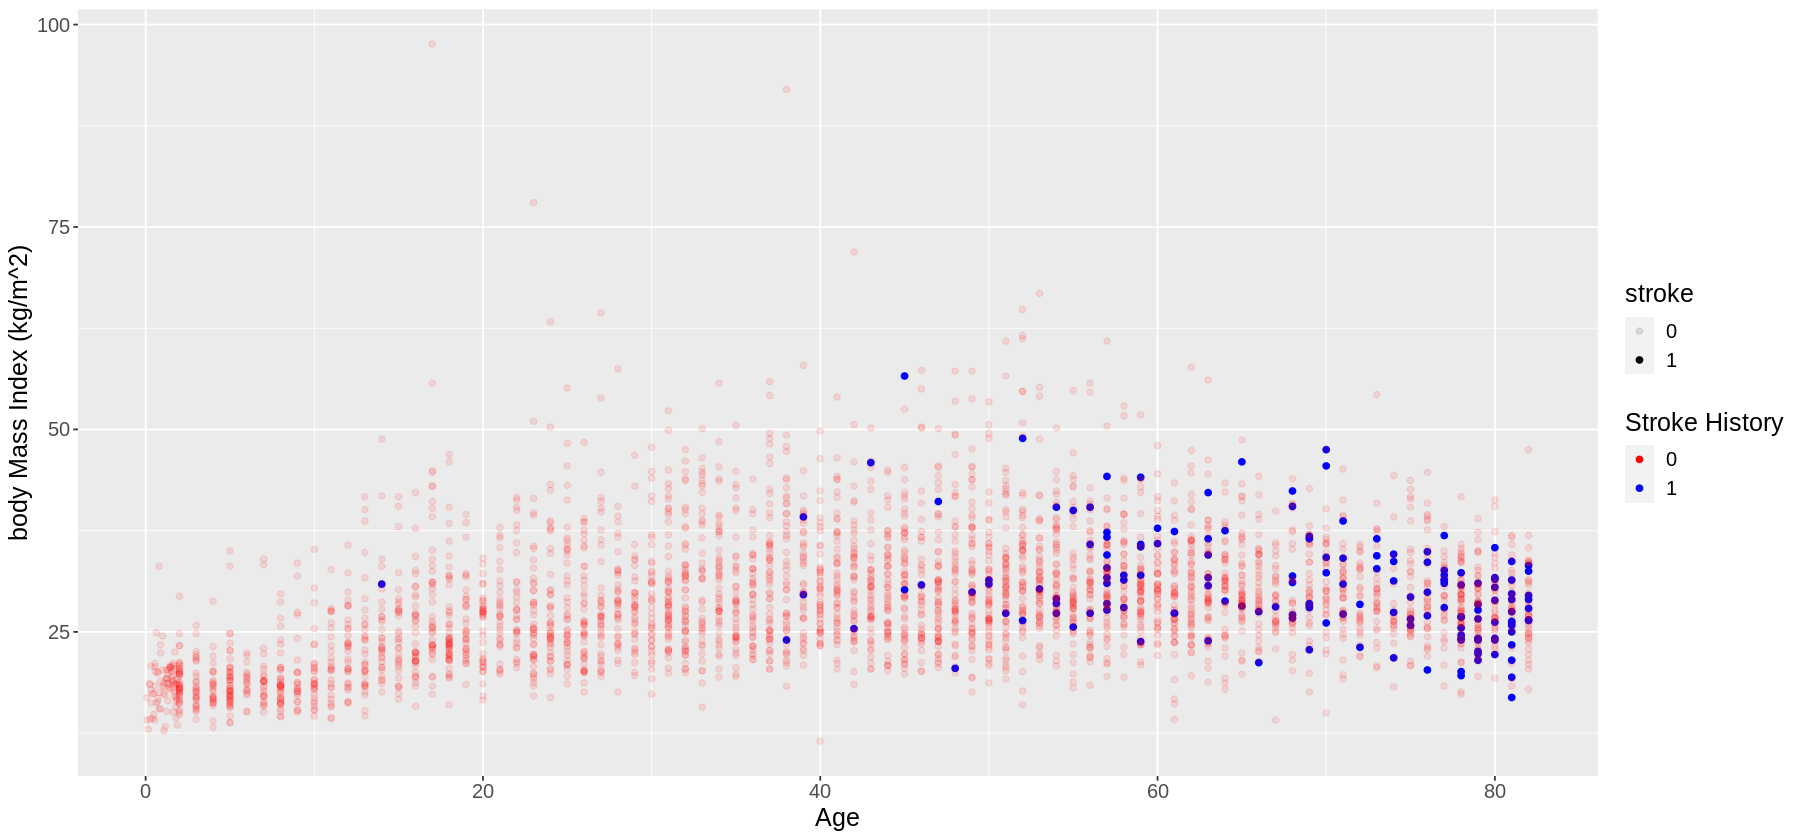

In [5]:
age_vs_bmi <- ggplot (stroke_train, aes(x=age, y=bmi, color= stroke))+
                geom_point(aes(alpha = stroke))+
                scale_alpha_manual(values = c(0.1, 1))+
                scale_color_manual(values = c("red", "blue"))+
                labs(x="Age", y="body Mass Index (kg/m^2)", color = "Stroke History")+
                theme(text = element_text(size = 15))
options(repr.plot.width = 15, repr.plot.length = 20)

age_vs_bmi

Warning message:
“Removed 156 rows containing missing values (geom_point).”


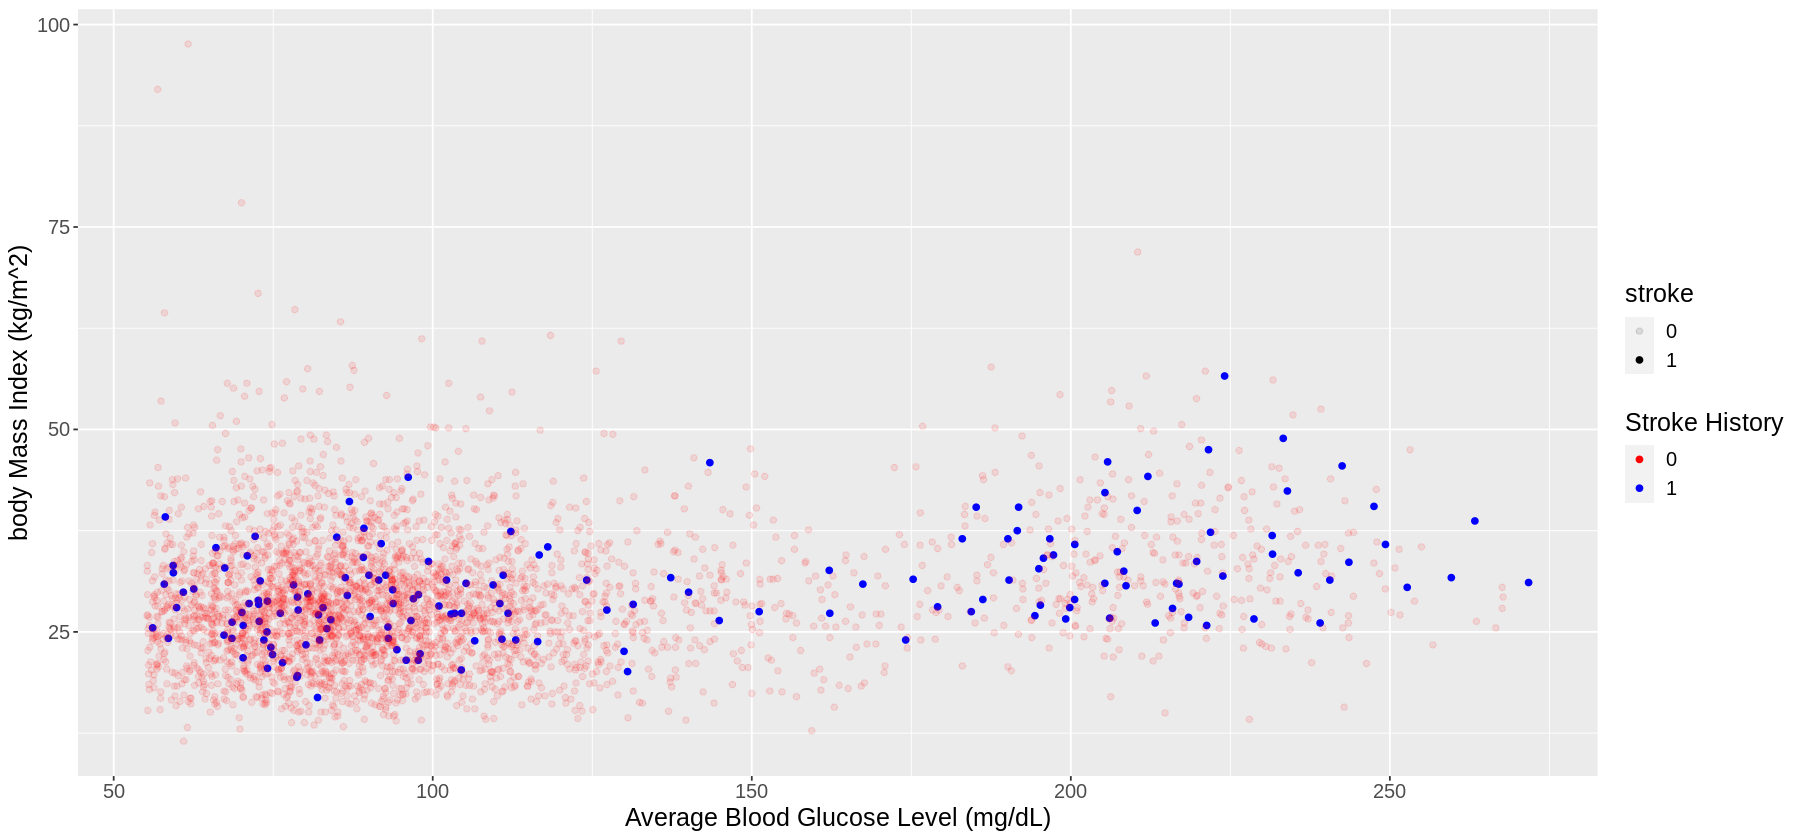

In [6]:
avg_glucose_vs_bmi <- ggplot (stroke_train, aes(x=avg_glucose_level, y=bmi, color= stroke))+
                geom_point(aes(alpha = stroke))+
                scale_alpha_manual(values = c(0.1, 1))+
                scale_color_manual(values = c("red", "blue"))+
                labs(x="Average Blood Glucose Level (mg/dL)", y="body Mass Index (kg/m^2)", color = "Stroke History")+
                theme(text = element_text(size = 15))
options(repr.plot.width = 15, repr.plot.length = 20)

avg_glucose_vs_bmi